In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from minisom import MiniSom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict

# Para gráficos inline (no Jupyter)
%matplotlib inline

In [3]:
# Ajuste o caminho se necessário
csv_path = "ag_news_prompts.csv"

df = pd.read_csv(csv_path)
print(df.head())
print("N exemplos:", len(df))
print("Colunas:", df.columns.tolist())


   id                           prompt_name  \
0   0                              classify   
1   1               classify_question_first   
2   2                 classify_with_choices   
3   3  classify_with_choices_question_first   
4   4                             recommend   

                                               input              target  \
0  Wall St. Bears Claw Back Into the Black (Reute...            Business   
1  What label best describes this news article?\n...            Business   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...            Business   
3  Is this a piece of news regarding world politi...            Business   
4  Would you recommend the following article to a...  Business executive   

                                       original_text  original_label  
0  Wall St. Bears Claw Back Into the Black (Reute...               2  
1  Carlyle Looks Toward Commercial Aerospace (Reu...               2  
2  Oil and Economy Cloud Stocks' Outlook (Reute

In [4]:
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Aqui usamos o campo 'input' (o texto do prompt)
texts = df["input"].astype(str).tolist()

embs = model.encode(texts, batch_size=32, show_progress_bar=True)
embs = embs / np.linalg.norm(embs, axis=1, keepdims=True)

print("Shape dos embeddings:", embs.shape)  # (N, dim)


Batches: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

Shape dos embeddings: (100, 384)


In [5]:
som_x, som_y = 10, 10  # pode ajustar
input_len = embs.shape[1]

som = MiniSom(som_x, som_y, input_len,
              sigma=1.0,
              learning_rate=0.5,
              neighborhood_function='gaussian',
              random_seed=42)

# Inicialização com dados reais
som.random_weights_init(embs)

num_iters = 10000  # ajuste dependendo do N
print("Treinando SOM...")
som.train_random(embs, num_iters)
print("Treino concluído.")


Treinando SOM...
Treino concluído.


In [6]:
# Métricas de qualidade do SOM
qe = som.quantization_error(embs)
te = som.topographic_error(embs)

print("=" * 50)
print("MÉTRICAS DE QUALIDADE DO SOM")
print("=" * 50)
print(f"Quantization Error: {qe:.6f}")
print(f"Topographic Error:  {te:.6f}")
print("=" * 50)
print("\nInterpretação:")
print("- Quantization Error: distância média entre vetores e seus BMUs (menor = melhor)")
print("- Topographic Error: % de vetores cujo 1º e 2º BMU não são vizinhos (menor = melhor)")


MÉTRICAS DE QUALIDADE DO SOM
Quantization Error: 0.124688
Topographic Error:  0.450000

Interpretação:
- Quantization Error: distância média entre vetores e seus BMUs (menor = melhor)
- Topographic Error: % de vetores cujo 1º e 2º BMU não são vizinhos (menor = melhor)


In [7]:
bmus = [som.winner(v) for v in embs]
df["som_x"] = [b[0] for b in bmus]
df["som_y"] = [b[1] for b in bmus]

df.head()


,id,prompt_name,input,target,original_text,original_label,som_x,som_y
0,0,classify,Wall St. Bears Claw Back Into the Black (Reute...,Business,Wall St. Bears Claw Back Into the Black (Reute...,2,3,2
1,1,classify_question_first,What label best describes this news article?\n...,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,2,9,4
2,2,classify_with_choices,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,6,1
3,3,classify_with_choices_question_first,Is this a piece of news regarding world politi...,Business,Iraq Halts Oil Exports from Main Southern Pipe...,2,5,1
4,4,recommend,Would you recommend the following article to a...,Business executive,"Oil prices soar to all-time record, posing new...",2,7,0


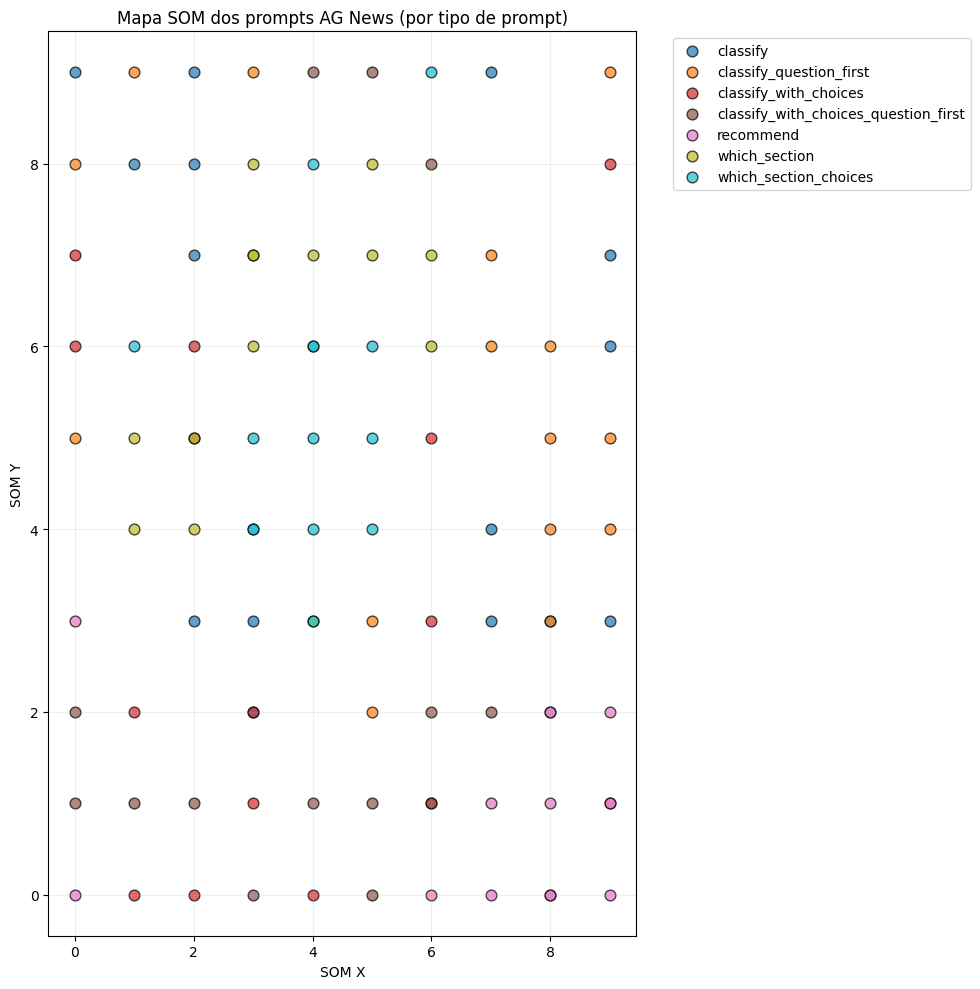

In [8]:
plt.figure(figsize=(10, 10))

# Categorias (tipos de prompt)
prompt_types = df["prompt_name"].unique()
colors = cm.tab10(np.linspace(0, 1, len(prompt_types)))

type_to_color = {t: c for t, c in zip(prompt_types, colors)}

for t in prompt_types:
    subset = df[df["prompt_name"] == t]
    xs = subset["som_x"].values
    ys = subset["som_y"].values
    plt.scatter(xs, ys, c=[type_to_color[t]], label=t, alpha=0.7, edgecolors='k', s=60)

plt.title("Mapa SOM dos prompts AG News (por tipo de prompt)")
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [9]:
def recommend_positive_only(prompt_idx, k=5, radius=2):
    """
    Recomenda prompts mais próximos do BMU do prompt dado.
    
    Args:
        prompt_idx: índice do prompt de referência no DataFrame
        k: número de recomendações
        radius: raio de busca no SOM
    
    Returns:
        DataFrame com os k prompts mais similares
    """
    # Embedding do prompt de referência
    prompt_emb = embs[prompt_idx]
    
    # Achar o neurônio vencedor (BMU)
    bmu = som.winner(prompt_emb)
    
    # Pegar vizinhança do BMU
    neighbors = []
    for i in range(max(0, bmu[0] - radius), min(som_x, bmu[0] + radius + 1)):
        for j in range(max(0, bmu[1] - radius), min(som_y, bmu[1] + radius + 1)):
            neighbors.append((i, j))
    
    # Filtrar prompts que caíram nessa vizinhança (exceto o próprio)
    candidates_idx = []
    for idx in range(len(df)):
        if idx == prompt_idx:
            continue
        if (df.iloc[idx]['som_x'], df.iloc[idx]['som_y']) in neighbors:
            candidates_idx.append(idx)
    
    if len(candidates_idx) == 0:
        print(f"Nenhum vizinho encontrado no raio {radius}. Tente aumentar o raio.")
        return pd.DataFrame()
    
    # Calcular similaridade de cosseno entre o prompt e os candidatos
    candidate_embs = embs[candidates_idx]
    sims = np.dot(candidate_embs, prompt_emb)  # já normalizado
    
    # Pegar top-k
    topk_local_idx = np.argsort(sims)[-k:][::-1]
    topk_idx = [candidates_idx[i] for i in topk_local_idx]
    
    result = df.iloc[topk_idx].copy()
    result['similarity'] = sims[topk_local_idx]
    
    return result[['id', 'prompt_name', 'input', 'target', 'similarity']]

# Exemplo: recomendar para o prompt 0
print("=" * 80)
print("ESTRATÉGIA: POSITIVE ONLY")
print("=" * 80)
print(f"\nPrompt de referência (id=0):")
print(f"  Tipo: {df.iloc[0]['prompt_name']}")
print(f"  Input: {df.iloc[0]['input'][:100]}...")
print(f"  BMU: ({df.iloc[0]['som_x']}, {df.iloc[0]['som_y']})")
print("\nRecomendações (top 5 mais próximos):")
recommendations = recommend_positive_only(0, k=5, radius=3)
print(recommendations.to_string(index=False))


ESTRATÉGIA: POSITIVE ONLY

Prompt de referência (id=0):
  Tipo: classify
  Input: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...
  BMU: (3, 2)

Recomendações (top 5 mais próximos):
 id             prompt_name                                                                                                                                                                                                                                                                                                                                                                                                                     input   target  similarity
  9   classify_with_choices                                                                                                                                                                      Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of 

In [10]:
def recommend_positive_and_negative(prompt_idx, k_pos=3, k_neg=2, radius_pos=2, radius_neg=5):
    """
    Recomenda prompts mais próximos (positive) E mais afastados (negative) do BMU.
    
    Args:
        prompt_idx: índice do prompt de referência
        k_pos: número de recomendações positivas (próximas)
        k_neg: número de recomendações negativas (distantes)
        radius_pos: raio para buscar positivos
        radius_neg: raio mínimo para buscar negativos
    
    Returns:
        dict com 'positive' e 'negative' DataFrames
    """
    prompt_emb = embs[prompt_idx]
    bmu = som.winner(prompt_emb)
    
    # === POSITIVOS: vizinhança próxima ===
    neighbors_pos = []
    for i in range(max(0, bmu[0] - radius_pos), min(som_x, bmu[0] + radius_pos + 1)):
        for j in range(max(0, bmu[1] - radius_pos), min(som_y, bmu[1] + radius_pos + 1)):
            neighbors_pos.append((i, j))
    
    pos_candidates_idx = []
    for idx in range(len(df)):
        if idx == prompt_idx:
            continue
        if (df.iloc[idx]['som_x'], df.iloc[idx]['som_y']) in neighbors_pos:
            pos_candidates_idx.append(idx)
    
    # === NEGATIVOS: regiões distantes no mapa ===
    neg_candidates_idx = []
    for idx in range(len(df)):
        if idx == prompt_idx:
            continue
        node = (df.iloc[idx]['som_x'], df.iloc[idx]['som_y'])
        # Distância Manhattan no mapa
        dist = abs(node[0] - bmu[0]) + abs(node[1] - bmu[1])
        if dist >= radius_neg:  # longe no mapa
            neg_candidates_idx.append(idx)
    
    # Calcular similaridades
    result = {}
    
    if pos_candidates_idx:
        pos_embs = embs[pos_candidates_idx]
        pos_sims = np.dot(pos_embs, prompt_emb)
        topk_pos_local = np.argsort(pos_sims)[-k_pos:][::-1]
        topk_pos_idx = [pos_candidates_idx[i] for i in topk_pos_local]
        
        result['positive'] = df.iloc[topk_pos_idx].copy()
        result['positive']['similarity'] = pos_sims[topk_pos_local]
    else:
        result['positive'] = pd.DataFrame()
    
    if neg_candidates_idx:
        neg_embs = embs[neg_candidates_idx]
        neg_sims = np.dot(neg_embs, prompt_emb)
        # Para negativos, pegar os MENOS similares
        topk_neg_local = np.argsort(neg_sims)[:k_neg]
        topk_neg_idx = [neg_candidates_idx[i] for i in topk_neg_local]
        
        result['negative'] = df.iloc[topk_neg_idx].copy()
        result['negative']['similarity'] = neg_sims[topk_neg_local]
    else:
        result['negative'] = pd.DataFrame()
    
    return result

# Exemplo: recomendar para o prompt 10
print("=" * 80)
print("ESTRATÉGIA: POSITIVE AND NEGATIVE")
print("=" * 80)
test_idx = 10
print(f"\nPrompt de referência (id={test_idx}):")
print(f"  Tipo: {df.iloc[test_idx]['prompt_name']}")
print(f"  Input: {df.iloc[test_idx]['input'][:100]}...")
print(f"  BMU: ({df.iloc[test_idx]['som_x']}, {df.iloc[test_idx]['som_y']})")

recommendations = recommend_positive_and_negative(test_idx, k_pos=3, k_neg=2)

print("\n--- POSITIVOS (mais próximos no SOM) ---")
if not recommendations['positive'].empty:
    print(recommendations['positive'][['id', 'prompt_name', 'similarity']].to_string(index=False))
else:
    print("Nenhum positivo encontrado.")

print("\n--- NEGATIVOS (mais distantes no SOM) ---")
if not recommendations['negative'].empty:
    print(recommendations['negative'][['id', 'prompt_name', 'similarity']].to_string(index=False))
else:
    print("Nenhum negativo encontrado.")


ESTRATÉGIA: POSITIVE AND NEGATIVE

Prompt de referência (id=10):
  Tipo: classify_with_choices_question_first
  Input: Is this a piece of news regarding world politics, sports, business, or science and technology?
Oil a...
  BMU: (6, 1)

--- POSITIVOS (mais próximos no SOM) ---
 id                          prompt_name  similarity
  2                classify_with_choices    0.962069
  3 classify_with_choices_question_first    0.627084
 13                which_section_choices    0.543360

--- NEGATIVOS (mais distantes no SOM) ---
 id             prompt_name  similarity
 91                classify    0.090951
 43 classify_question_first    0.095819


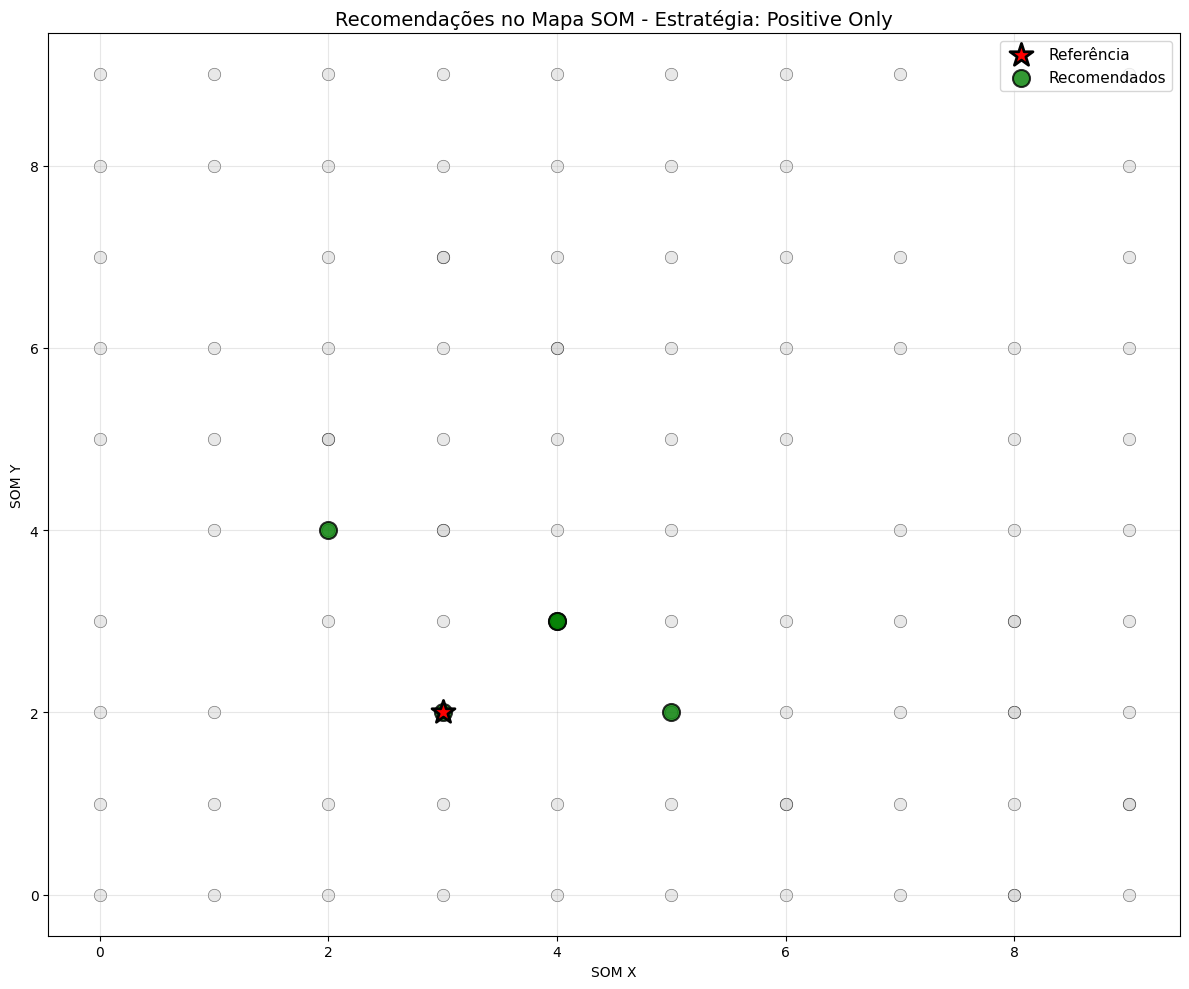

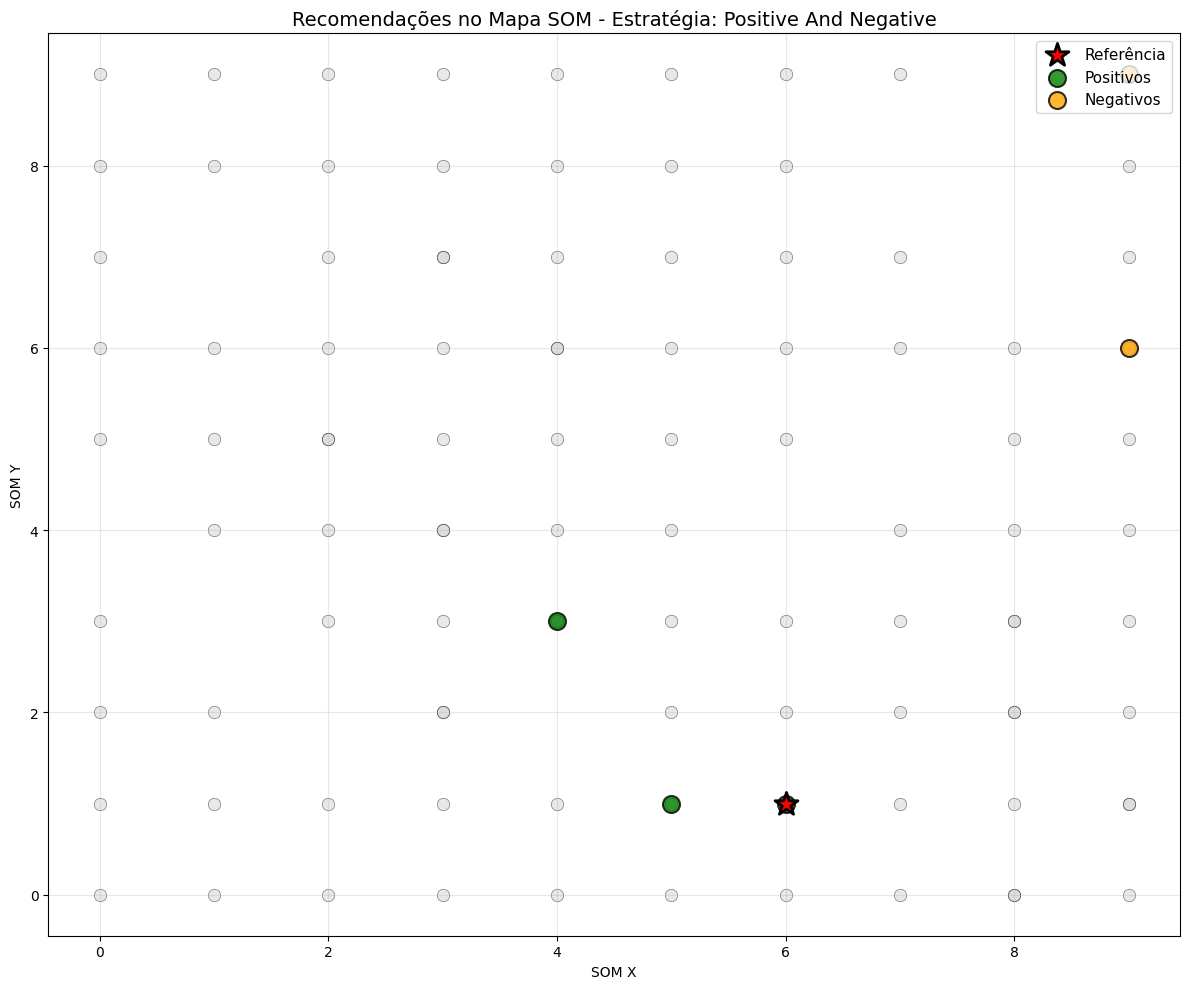

In [11]:
def plot_recommendations(prompt_idx, recommendations, strategy='positive_only'):
    """
    Plota o mapa SOM destacando o prompt de referência e as recomendações.
    """
    plt.figure(figsize=(12, 10))
    
    # Plotar todos os prompts (cinza claro)
    plt.scatter(df['som_x'], df['som_y'], c='lightgray', s=80, alpha=0.5, edgecolors='k', linewidth=0.5)
    
    # Destacar o prompt de referência (vermelho)
    ref_x = df.iloc[prompt_idx]['som_x']
    ref_y = df.iloc[prompt_idx]['som_y']
    plt.scatter([ref_x], [ref_y], c='red', s=300, marker='*', edgecolors='black', linewidths=2, label='Referência', zorder=5)
    
    # Destacar recomendações
    if strategy == 'positive_only':
        rec_ids = recommendations['id'].values
        rec_df = df[df['id'].isin(rec_ids)]
        plt.scatter(rec_df['som_x'], rec_df['som_y'], c='green', s=150, alpha=0.8, edgecolors='black', linewidths=1.5, label='Recomendados', zorder=4)
    
    elif strategy == 'positive_and_negative':
        if not recommendations['positive'].empty:
            pos_ids = recommendations['positive']['id'].values
            pos_df = df[df['id'].isin(pos_ids)]
            plt.scatter(pos_df['som_x'], pos_df['som_y'], c='green', s=150, alpha=0.8, edgecolors='black', linewidths=1.5, label='Positivos', zorder=4)
        
        if not recommendations['negative'].empty:
            neg_ids = recommendations['negative']['id'].values
            neg_df = df[df['id'].isin(neg_ids)]
            plt.scatter(neg_df['som_x'], neg_df['som_y'], c='orange', s=150, alpha=0.8, edgecolors='black', linewidths=1.5, label='Negativos', zorder=4)
    
    plt.title(f"Recomendações no Mapa SOM - Estratégia: {strategy.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel("SOM X")
    plt.ylabel("SOM Y")
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Exemplo: plotar recomendação positive_only para o prompt 0
rec_pos_only = recommend_positive_only(0, k=5, radius=3)
plot_recommendations(0, rec_pos_only, strategy='positive_only')

# Exemplo: plotar recomendação positive_and_negative para o prompt 10
rec_pos_neg = recommend_positive_and_negative(10, k_pos=3, k_neg=2)
plot_recommendations(10, rec_pos_neg, strategy='positive_and_negative')
